# Airframe Analysis

In [2]:
using VortexLattice
using Plots
using StaticArrays
include("MyVortexLattice.jl")
import .MyVortexLattice

## Lift distribution and efficiency

Use a single elliptical wing with a varying number of sections to show how as a wing gets more elliptical, it gets more efficient. Notice that the end segment gets cut off, so start analysis with 10 segments to assure that no more than 1/10 of the wing is missing.

In [5]:
#define parameters
wing_root_chord = 5
wing_span = 20
wing_angle = 2
spanwise_sections = 10:100

# Set up freestream parameters
alpha = -4.0 * pi / 180 # angle of attack
beta = 0.0 # sideslip angle
Omega = [0.0, 0.0, 0.0] # rotational velocity around the reference location
Vinf = 1.0 # reference velocity
fs = Freestream(Vinf, alpha, beta, Omega)

# Initialize reference location and symmetric option
rref = SVector(0.50, 0.0, 0.0) # using StaticArrays for fixed-size vector
symmetric = true

# Initialize vectors to store results for each coefficient
CDs, CLs = Float64[], Float64[]
Cms = Float64[]
CDiffs = Float64[]

# Run analysis for each spanwise section count
for n in spanwise_sections
    # geometry for the right half of the wing
    wing_xyz, wing_reference_area, wing_reference_chord = 
        MyVortexLattice.grid_from_elliptical_edge(wing_root_chord, wing_span, 6, n, wing_angle, 0, 0, false)

    # reference parameters for each section count
    ref = Reference(wing_reference_area, wing_reference_chord, wing_span, rref, Vinf)

    # construct surface
    wing_grid, wing_surface = grid_to_surface_panels(wing_xyz, mirror = false)
    
    # create vector containing the surface and perform steady state analysis
    surfaces = [wing_surface]
    system = steady_analysis(surfaces, ref, fs; symmetric=symmetric)
    
    # retrieve near-field forces
    CF, CM = body_forces(system; frame=Wind())
    CD, -, CL = CF
    -, Cm, - = CM
    
    # retrieve far-field drag
    CDiff = far_field_drag(system)
    
    # Append the results for each coefficient
    push!(CDs, CD)
    push!(CLs, CL)
    push!(Cms, Cm)
    push!(CDiffs, CDiff)
end

println()

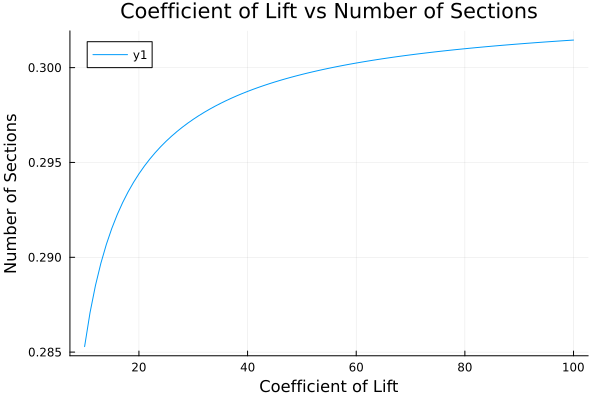

In [6]:
plot(spanwise_sections, CLs)
plot!(title = "Coefficient of Lift vs Number of Sections", ylabel = "Number of Sections", xlabel = "Coefficient of Lift")

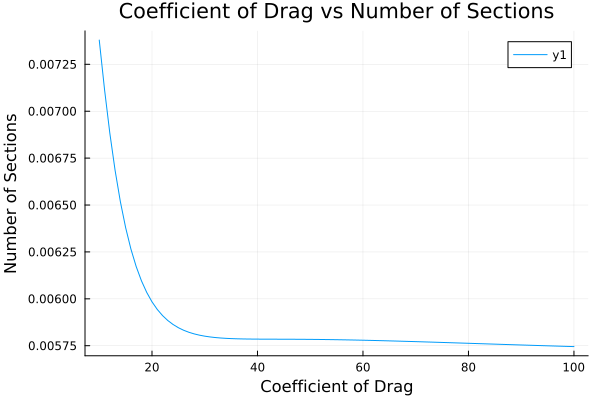

In [7]:
plot(spanwise_sections, CDs)
plot!(title = "Coefficient of Drag vs Number of Sections", ylabel = "Number of Sections", xlabel = "Coefficient of Drag")

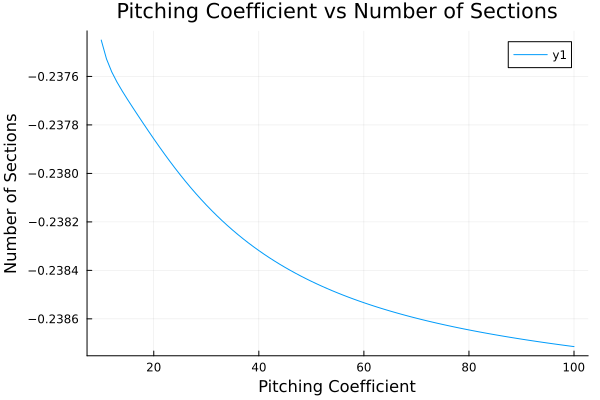

In [8]:
plot(spanwise_sections, Cms)
plot!(title = "Pitching Coefficient vs Number of Sections", ylabel = "Number of Sections", xlabel = "Pitching Coefficient")

As the number of sections used increases, the coefficient of lift increases while the coefficients for drag and the pitching moment both decrease.

## Horizontal and Vertical Tail Volume Ratios and Stability Derivatives

Have the wing in a fixed location. Have the size of the tail wings stay the same, but move them (together) further and further back along the aircraft.

In [60]:
#define wing parameters
wing_root_chord = 5
wing_span = 20
wing_angle = 5
spanwise_sections = 60

#define tail parameters
tail_root_chord = 2
horizontal_tail_span = 5 
initial_tail_x_placement = 5
tail_z_placement = 1
vertical_tail_span = 5

# Set up freestream parameters
alpha = -1.0 * pi / 180 # angle of attack
beta = 0.0 # sideslip angle
Omega = [0.0, 0.0, 0.0] # rotational velocity around the reference location
Vinf = 1.0 # reference velocity
fs = Freestream(Vinf, alpha, beta, Omega)

# Initialize reference location and symmetric option
rref = SVector(0.50, 0.0, 0.0) # using StaticArrays for fixed-size vector
symmetric = false

# geometry for the right half of the wing
wing_xyz, wing_reference_area, wing_reference_chord = 
    MyVortexLattice.grid_from_elliptical_edge(wing_root_chord, wing_span, 6, spanwise_sections, wing_angle, 0, 0, false)

# construct wing surface
wing_grid, wing_surface = grid_to_surface_panels(wing_xyz, mirror = true)

# reference parameters (determined by the wing)
ref = Reference(wing_reference_area, wing_reference_chord, wing_span, rref, Vinf)

# Initialize vectors to store results for each derivative
dCFs, dCMs = [], []
horizontal_ratios = []
vertical_ratios = []

# Run analysis for each spanwise section count
for n in range(0, 2000)
    tail_x_placement = initial_tail_x_placement + (0.1 * n)

    #create the horizontal tail geometry
    horizontal_tail_xyz, horizontal_tail_reference_area, horizontal_tail_reference_chord = 
        MyVortexLattice.grid_from_elliptical_edge(tail_root_chord, horizontal_tail_span, 6,
        spanwise_sections, 0, tail_x_placement, tail_z_placement, false)
    
    #geometry for vertical tail
    vertical_tail_xyz, vertical_tail_reference_area, vertical_tail_reference_chord = 
        MyVortexLattice.grid_from_elliptical_edge(tail_root_chord, vertical_tail_span, 6,
        spanwise_sections, 0, tail_x_placement, tail_z_placement, true)

    #construct vertical tail surface
    vertical_tail_grid, vertical_tail_surface = grid_to_surface_panels(vertical_tail_xyz, mirror = false)

    #construct the horizontal tail surface
    horizontal_tail_grid, horizontal_tail_surface = grid_to_surface_panels(horizontal_tail_xyz, mirror = true)

    # create vector containing the surfaces and perform steady state analysis
    surfaces = [wing_surface, horizontal_tail_surface, vertical_tail_surface]
    system = steady_analysis(surfaces, ref, fs; symmetric=symmetric)
    
    # retrieve near-field forces
    #CF, CM = body_forces(system; frame=Wind())

    #retreive stability derivatives
    body_derivatives(system)
    dCF, dCM = stability_derivatives(system)

    #calculate volume ratios
    x = (tail_x_placement + (horizontal_tail_reference_chord / 4)) - 0.5
    horizontal_ratio = (horizontal_tail_reference_area * x) / (wing_reference_area * wing_reference_chord)
    vertical_ratio = (vertical_tail_reference_area * x) / (wing_reference_area * wing_span)
    
    # Append the results for each coefficient
    push!(dCFs, dCF)
    push!(dCMs, dCM)
    push!(horizontal_ratios, horizontal_ratio)
    push!(vertical_ratios, vertical_ratio)
end

In [64]:
println(dCFs[500])
println(dCMs[500])
println(horizontal_ratios[500])
println(vertical_ratios[500])

(alpha = [2.6196215565459943e11, -4.993689337426154e10, 2.152146502629841e9], beta = [-1.5457358053365195e13, 4.662355692116036e12, -4.374777769412241e11], p = [-3.1000666624860523e13, 5.112795350194878e12, -8.548783044200162e11], q = [3.1974499283940195e12, -7.220279988822189e11, 9.9915903997783e10], r = [9.618635982007095e13, -1.9446819993814883e13, 2.485090994356796e12])
(alpha = [-7.484659474975195e9, 2.30786415850671e10, 1.303153274873592e11], beta = [4.4396806830835187e11, -1.7839957400874773e12, -1.2077570276621031e13], p = [4.868243204662196e11, -3.867445114831358e12, -1.3242323235115812e13], q = [-6.895430157982375e10, 2.429246786231421e11, 1.8818264217515774e12], r = [-1.8524327021298477e12, 1.4168989362212775e13, 5.041193438071688e13])
1.404864744481894
0.1369750049281697


## Angle of Attack and Lift Coefficient

Have again, a single elliptic wing and this time, vary the freestream velocity (angle of attack), and record the results.

In [78]:
#define parameters
wing_root_chord = 5
wing_span = 20
wing_angle = 1
spanwise_sections = 60

# Set up freestream parameters
alpha = (-10:25) .* (-pi / 180) # angle of attack
beta = 0.0 # sideslip angle
Omega = [0.0, 0.0, 0.0] # rotational velocity around the reference location
Vinf = 1.0 # reference velocity

# Initialize reference location and symmetric option
rref = SVector(0.50, 0.0, 0.0) # using StaticArrays for fixed-size vector
symmetric = true

# geometry for the right half of the wing
    wing_xyz, wing_reference_area, wing_reference_chord = 
        MyVortexLattice.grid_from_elliptical_edge(wing_root_chord, wing_span, 6, spanwise_sections, wing_angle, 0, 0, false)

# reference parameters for each section count
ref = Reference(wing_reference_area, wing_reference_chord, wing_span, rref, Vinf)

# construct surface
wing_grid, wing_surface = grid_to_surface_panels(wing_xyz, mirror = false)
    
# create vector containing the surface
surfaces = [wing_surface]

# Initialize vectors to store results for each coefficient
CLs = Float64[]

# Run analysis for each spanwise section count
for i in range(1,length(alpha))
    
    fs = Freestream(Vinf, alpha[i], beta, Omega)
    
    system = steady_analysis(surfaces, ref, fs; symmetric=symmetric)
    
    # retrieve near-field forces
    CF, CM = body_forces(system; frame=Wind())
    -, -, CL = CF
    
    # Append the results for each coefficient
    push!(CLs, CL)
end

println()

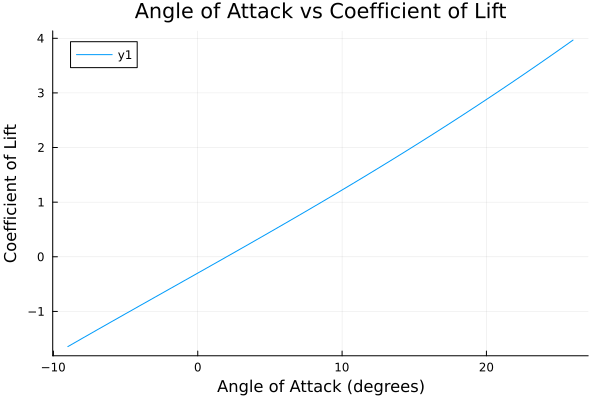

In [80]:
plot(1 .+ (alpha .* (-180/pi)), CLs)
plot!(title = "Angle of Attack vs Coefficient of Lift")
plot!(ylabel = "Coefficient of Lift", xlabel = "Angle of Attack (degrees)")

The wing is modeled as being completely level. This means that the lift shown is almost purely from Newton's third law, and is quite nearly linear - even when the wing should have stalled. (note that the wing is at its own angle, otherwise the result goes nuts.)

In [100]:
#define parameters
wing_root_chord = 5
wing_span = 20
wing_angle = 0
spanwise_sections = 60

# Set up freestream parameters
alpha = (-5:10) .* (-pi / 180) # angle of attack
beta = 0.0 # sideslip angle
Omega = [0.0, 0.0, 0.0] # rotational velocity around the reference location
Vinf = 1.0 # reference velocity

# Initialize reference location and symmetric option
rref = SVector(0.50, 0.0, 0.0) # using StaticArrays for fixed-size vector
symmetric = true

# geometry for the right half of the wing
    wing_xyz, wing_reference_area, wing_reference_chord = 
        MyVortexLattice.grid_from_elliptical_edge(wing_root_chord, wing_span, 6, spanwise_sections, wing_angle, 0, 0, false)

# reference parameters for each section count
ref = Reference(wing_reference_area, wing_reference_chord, wing_span, rref, Vinf)

# construct surface
wing_grid, wing_surface = grid_to_surface_panels(wing_xyz, mirror = false)
    
# create vector containing the surface
surfaces = [wing_surface]

# Initialize vectors to store results for each coefficient
CLs = Float64[]

# Run analysis for each spanwise section count
for i in range(1,length(alpha))
    
    fs = Freestream(Vinf, alpha[i], beta, Omega)
    
    system = steady_analysis(surfaces, ref, fs; symmetric=symmetric)
    
    # retrieve near-field forces
    CF, CM = body_forces(system; frame=Wind())
    -, -, CL = CF
    
    # Append the results for each coefficient
    push!(CLs, CL)
end

println()

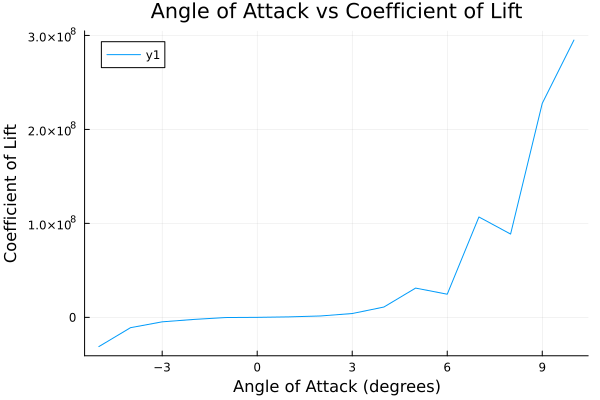

In [102]:
plot((alpha .* (-180/pi)), CLs)
plot!(title = "Angle of Attack vs Coefficient of Lift")
plot!(ylabel = "Coefficient of Lift", xlabel = "Angle of Attack (degrees)")